# Fine Tuning Stable Diffusion on "any" dataset
*By Raphael Bernas*

This code is adapted from "Stable Diffusion Model Fine-tuning" by Yi Chen.

https://medium.com/@chenyiapp1128/stable-diffusion-model-fine-tuning-ce577aceb60c

In [1]:
!pip install transformers diffusers datasets accelerate torch torchvision
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from huggingface_hub import login
from google.colab import userdata

hf_token = userdata.get('HF_TOKEN')
login(token=hf_token, add_to_git_credential=True)

In [3]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, StableDiffusionPipeline
import torch

# Load model
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# Load device
device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare the model
unet = unet.to(device)
vae = vae.to(device)
text_encoder = text_encoder.to(device)

pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    vae=vae,
    unet=unet,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    scheduler=scheduler,
    torch_dtype=torch.float16,

)

pipe = pipe.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.


In [4]:

import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
from io import BytesIO
import numpy as np

def preprocess_function(examples):
    for i in range(len(examples['image'])):
        image = examples['image'][i]
        image_size = examples['image_size'][i]
        # Reshape the image array to its original shape
        image_array = np.reshape(image, image_size)
        # Convert the NumPy array to a PIL Image
        examples['image'][i] = Image.fromarray(image_array.astype(np.uint8)).convert("RGB")

    transform = transforms.ToTensor()

    images = [transform(image.convert("RGB").resize((vae.config.sample_size, vae.config.sample_size))) for image in examples['image']]
    images = torch.stack(images).to(device)

    with torch.no_grad():
        latents = vae.encode(images).latent_dist.sample().detach()
    latents = latents * 0.18215
    latents = latents.half()

    inputs = tokenizer(
        examples["caption"],
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    )

    with torch.no_grad():
        encoder_hidden_states = text_encoder(input_ids=inputs.input_ids.to(device),
                                             attention_mask=inputs.attention_mask.to(device)).last_hidden_state.half()

    examples["pixel_values"] = latents
    examples["input_ids"] = inputs.input_ids
    examples["attention_mask"] = inputs.attention_mask
    examples["encoder_hidden_states"] = encoder_hidden_states
    if latents is None or inputs.input_ids is None or encoder_hidden_states is None or inputs.attention_mask is None:
        print("NoneType appeared")
    return examples


In [5]:
# Path to the repository to save the loaded dataset
save_path = "text_to_image_subset"

# Dataset name, key, split
dataset_name = "jackyhate/text-to-image-2M"
dataset_key = {'image': 'jpg', # key to access the image in the dataset
               'caption' : 'prompt', # key to access the caption/ text in dataset
               'intermediary_to_image' : None, # in case there is an intermediary to reach image in the dataset
               'intermediary_to_caption' : 'json' # in case there is an intermediary to reach text in the dataset
               }
dataset_split = "train"

# Number of sample loaded from the dataset
power = 2
num_examples = 10**power

# Criteria on image/ text to keep in the dataset
def criteria(text, image):
    return False

In [17]:
# Path to the repository to save the loaded dataset
save_path = "text_to_image_subset"

# Dataset name, key, split
dataset_name = "Artificio/WikiArt_Full"
dataset_key = {'image': 'image', # key to access the image in the dataset
               'caption' : 'description', # key to access the caption/ text in dataset
               'intermediary_to_image' : None, # in case there is an intermediary to reach image in the dataset
               'intermediary_to_caption' : None, # in case there is an intermediary to reach text in the dataset
               }
dataset_split = "train"

# Number of sample loaded from the dataset
power = 2
num_examples = 10**power

# Criteria on image/ text to keep in the dataset
def criteria(text, image):
    if 'Romanticism' in text :
        return True
    else :
        return False

In [6]:
from datasets import load_dataset, load_from_disk, Dataset
import pandas as pd
import os
import numpy as np
from PIL import Image

if os.path.exists(save_path):
    print(f"Dataset already exists at '{save_path}'. Loading from disk...")
    subset_dataset = load_from_disk(save_path)
else:
    # Load dataset
    ds_stream = load_dataset(dataset_name, split=dataset_split, streaming=True)
    k_count = 0
    bar_length = 30
    j = 0
    subset = []
    for i, example in enumerate(ds_stream):
        progress = (i+1-j)/num_examples
        if progress > k_count/bar_length :
            k_count += 1
            filled_length = int(bar_length * progress)  # Number of '#' characters
            bar = f"[{'#' * filled_length}{'.' * (bar_length - filled_length)}] {int(progress * 100)}%"
            print(bar)
        _example_ = {}
        text_example = example[dataset_key['caption']] if dataset_key['intermediary_to_caption'] is None else example[dataset_key['intermediary_to_caption']][dataset_key['caption']]
        image_example = np.array(example[dataset_key['image']]) if dataset_key['intermediary_to_image'] is None else np.array(example[dataset_key['intermediary_to_image']][dataset_key['image']])
        _example_['caption'] = text_example
        _example_['image_size'] = image_example.shape
        _example_['image'] = image_example.flatten()
        if text_example is None or image_example is None or criteria(text_example, image_example):
            j += 1
            print('Passed one example : "NoneType" or "Criteria"')
        else :
            subset.append(_example_)

        if i + 1 >= num_examples + j:
            break

    subset_dataset = Dataset.from_pandas(pd.DataFrame(subset))
    # Save the subset locally
    subset_dataset.save_to_disk(save_path)
    print("Subset saved to " + save_path)

dataset = subset_dataset.map(preprocess_function, batched=True, batch_size=10)


README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

[..............................] 1%
[#.............................] 4%
[##............................] 7%
[###...........................] 11%
[####..........................] 14%
[#####.........................] 17%
[######........................] 21%
[#######.......................] 24%
[########......................] 27%
[#########.....................] 31%
[##########....................] 34%
[###########...................] 37%
[############..................] 41%
[#############.................] 44%
[##############................] 47%
[###############...............] 51%
[################..............] 54%
[#################.............] 56%
[##################............] 61%
[###################...........] 64%
[####################..........] 67%
[#####################.........] 71%
[######################........] 74%
[#######################.......] 77%
[########################......] 81%
[#########################.....] 84%
[##########################....] 87%
[###

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Subset saved to text_to_image_subset


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [7]:
# We need to remove other colomn that could lead to problem in the dataloader
columns_to_keep = ["pixel_values", "input_ids", "attention_mask"] #"encoder_hidden_states"

reduced_dataset = dataset.remove_columns(
    [column for column in dataset.column_names if column not in columns_to_keep]
)

# Verify the new structure
print(reduced_dataset)
reduced_dataset.set_format("torch")

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask'],
    num_rows: 100
})


In [ ]:
# Unfreeze the U-net
vae.requires_grad_(False)
unet.train()


UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [ ]:
from torch.nn import functional as F
from torch.utils.data import DataLoader

# setting
train_dataloader = DataLoader(reduced_dataset, batch_size=2, shuffle=True)
num_epochs = 10

optimizer = torch.optim.Adam([
    #{"params": text_encoder.parameters(), "lr": 1e-4},
    {"params": unet.parameters(), "lr": 1e-5},
])

# Training
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Move data to GPU
        pixel_values = batch["pixel_values"].to(device) #.type(torch.float16)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Forward pass
        latents = pixel_values
        noise = torch.randn_like(latents).to(device)
        timesteps = torch.randint(0, 1000, (latents.size(0),), device=device).long()

        # Predict noise using the U-Net and CLIP Text Encoder
        text_embeddings = text_encoder(input_ids, attention_mask=attention_mask).last_hidden_state
        pred_noise = unet(latents, timesteps, encoder_hidden_states=text_embeddings).sample
        # if torch.isnan(text_embeddings).any():
        #     print("NaNs found in text embedding!")
        # Loss: MSE between predicted and true noise
        loss = F.mse_loss(pred_noise, noise)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(text_encoder.parameters(), 1.0)  # Clip gradients for the text encoder
        torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)         # Clip gradients for the U-Net
        optimizer.step()

    print(f"Epoch {epoch + 1}: Loss = {loss.item()}")


Epoch 1: Loss = 1.0214691162109375
Epoch 2: Loss = 1.0068308115005493
Epoch 3: Loss = 1.0093116760253906


  0%|          | 0/50 [00:00<?, ?it/s]

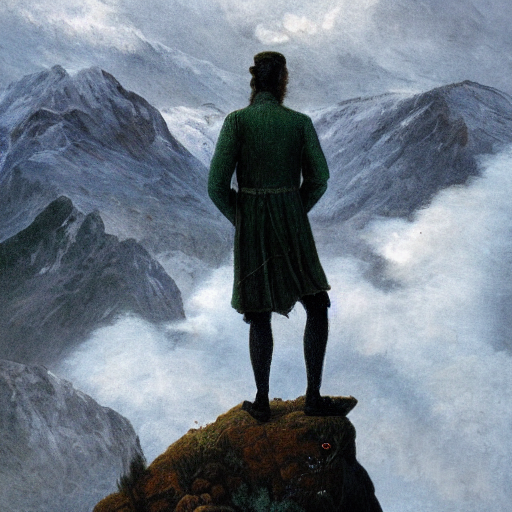

In [16]:
# Use the newly trained pipeline to produce an image :

prompt = 'a picture of a man standing at the top of a mountain in romanticism style'
resolution = 512
steps = 50

image = pipe(prompt, height=resolution, width=resolution, num_inference_steps=steps).images[0]

display(image)

# Citing for Stable Diffusion (BibTex)
@misc{rombach2021highresolution,
      title={High-Resolution Image Synthesis with Latent Diffusion Models},
      author={Robin Rombach and Andreas Blattmann and Dominik Lorenz and Patrick Esser and Björn Ommer},
      year={2021},
      eprint={2112.10752},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}